# Get the MVP - the mood of the song

## Import stuff

In [238]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

## Load data

In [134]:
data = pd.read_csv('./data_top10c_more_lyrics.csv')

In [135]:
data.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756


## Work the data a tiny bit

GOAL:<BR />
Focus on the columns that wont change (for each song/one song per row) -> predict mood (happy , neutral, sad) for song.<BR />

The columns will be:
- Track Name (general info)
- Artist (general info)
- ID (general info)
- Lyrics (TextBlob)
- Acousticness (make sure numerical)
- Energy (make sure numerical)
- Instrumentalness (make sure numerical)
- Mode (make sure numerical)
- Tempo (make sure numerical)
- Valence (make sure numerical)

**Drop rows that are duplicates and keep only one row for each song**

In [136]:
data_per_song = data.drop_duplicates(subset=['Track Name'], keep='first')

**Drop all columns that might change per song**

In [137]:
mvp_data = data_per_song.drop(['Unnamed: 0', 'Position', 'Streams', 'Date', 'Year', 'Month', 'Day', 'Country', 'Region'], axis=1)

mvp_data.head(5)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.04080,0.928,0.001040,0.0,172.656,0.8790
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.10300,0.939,0.000000,1.0,105.003,0.7560
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,NaN,0.91400,0.227,0.163000,1.0,81.887,0.0498
44,Zomersessie,101Barz,3ypzzvHUfgwyqxhL9ym4fH,NaN,0.00818,0.403,0.000021,1.0,155.748,0.3650
47,Zomersessie (feat. 3robi),101Barz,2re4cLViiQw0NZZx5KUpV8,NaN,0.00818,0.403,0.000021,1.0,155.748,0.3650


**Look at missing values and data type**

In [138]:
mvp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6919 entries, 0 to 578929
Data columns (total 10 columns):
Track Name          6919 non-null object
Artist              6919 non-null object
ID                  6919 non-null object
Lyrics              4190 non-null object
Acousticness        6918 non-null float64
Energy              6918 non-null float64
Instrumentalness    6918 non-null float64
Mode                6918 non-null float64
Tempo               6918 non-null float64
Valence             6918 non-null float64
dtypes: float64(6), object(4)
memory usage: 594.6+ KB


**Look at number off missing values in the Lyrics column**

In [139]:
mvp_data['Lyrics'].isnull().sum()

2729

**Look at the share of Tracks that have no Lyric**

In [140]:
2729/6919

0.39442115912704145

*I am missing lyrics for 39% of my songs -> I have lyrics for 61% of my songs*

### TextBlob

**Turn the lyrics in the Lyrics column into string**

In [141]:
mvp_data['Lyrics'] = mvp_data['Lyrics'].astype(str)

**Make and run function for TextBlob on the Lyrics**

Source: https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe

In [142]:
def sentiment_func(lyrics):
    try:
        return TextBlob(lyrics).sentiment
    except:
        return None

mvp_data['pol_sub'] = mvp_data['Lyrics'].apply(sentiment_func)

**Look at the new column with Polarity and Subjectivity from TextBlob**<BR />
Polarity (-1 to +1) (negative, positive)<BR />
Subjectivity (0 to 1) (objective, subjective)

In [143]:
mvp_data['pol_sub'].head(3)

0     (-0.044454619454619454, 0.5908017908017905)
1        (0.5831501831501833, 0.6706959706959708)
43                                     (0.0, 0.0)
Name: pol_sub, dtype: object

**Change order of the columns in the data frame**

In [144]:
mvp_data = mvp_data[['Track Name', 'Artist', 'ID', 'Lyrics', 'pol_sub', 'Acousticness', 'Energy', 'Instrumentalness',
                     'Mode', 'Tempo', 'Valence']]

**Split the pol_sub column into 2 new columns (Polarity, Subjectivity)**

In [145]:
mvp_data['pol_sub'][0][0]

mvp_data['Polarity'] = mvp_data['pol_sub'].apply(lambda x: x[0])
mvp_data['Subjectivity'] = mvp_data['pol_sub'].apply(lambda x: x[1])

mvp_data.head(3)

,Track Name,Artist,ID,Lyrics,pol_sub,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,Polarity,Subjectivity
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...","(-0.044454619454619454, 0.5908017908017905)",0.0408,0.928,0.00104,0.0,172.656,0.8790,-0.044455,0.590802
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,"(0.5831501831501833, 0.6706959706959708)",0.1030,0.939,0.00000,1.0,105.003,0.7560,0.583150,0.670696
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,nan,"(0.0, 0.0)",0.9140,0.227,0.16300,1.0,81.887,0.0498,0.000000,0.000000


**Drop rows that have missing values in the Lyrics column**<BR />
nan is a string and not a np.nan value<BR />
I can filter insted of using dropnan or notnull

In [146]:
mvp_data1 = mvp_data[mvp_data['Lyrics'] != 'nan']

**Check that things seem to have worked out as expected**

In [147]:
len(mvp_data1)

4190

In [148]:
mvp_data1.head(3)

,Track Name,Artist,ID,Lyrics,pol_sub,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,Polarity,Subjectivity
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...","(-0.044454619454619454, 0.5908017908017905)",0.0408,0.928,0.00104,0.0,172.656,0.879,-0.044455,0.590802
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,"(0.5831501831501833, 0.6706959706959708)",0.1030,0.939,0.00000,1.0,105.003,0.756,0.583150,0.670696
48,Somme,13 Block,2xkxBVJHf9jQsq7g46UtQx,"J'ai fait l'aller, j'suis sur le retour\nLa ma...","(0.1738095238095238, 0.5416666666666666)",0.4940,0.678,0.00151,0.0,79.979,0.528,0.173810,0.541667


**Drop the pol_sub column**

In [149]:
mvp_data1 = mvp_data1.drop(['pol_sub'], axis=1)

**Change the order of the columns**

In [150]:
mvp_data1 = mvp_data1[['Track Name', 'Artist', 'ID', 'Lyrics', 'Polarity', 'Subjectivity', 'Acousticness', 'Energy', 'Instrumentalness',
                     'Mode', 'Tempo', 'Valence']]

mvp_data1.columns

Index(['Track Name', 'Artist', 'ID', 'Lyrics', 'Polarity', 'Subjectivity',
       'Acousticness', 'Energy', 'Instrumentalness', 'Mode', 'Tempo',
       'Valence'],
      dtype='object')

### Do a quick check of the entire data frame

In [151]:
mvp_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 0 to 578929
Data columns (total 12 columns):
Track Name          4190 non-null object
Artist              4190 non-null object
ID                  4190 non-null object
Lyrics              4190 non-null object
Polarity            4190 non-null float64
Subjectivity        4190 non-null float64
Acousticness        4190 non-null float64
Energy              4190 non-null float64
Instrumentalness    4190 non-null float64
Mode                4190 non-null float64
Tempo               4190 non-null float64
Valence             4190 non-null float64
dtypes: float64(8), object(4)
memory usage: 425.5+ KB


In [152]:
mvp_data1.describe()

,Polarity,Subjectivity,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
count,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000
mean,0.071806,0.453405,0.238886,0.660887,0.009918,0.541050,120.254388,0.482520
std,0.225631,0.228036,0.234458,0.165181,0.065771,0.498372,26.560422,0.221104
min,-1.000000,0.000000,0.000003,0.027900,0.000000,0.000000,54.082000,0.037100
25%,-0.033272,0.350000,0.051525,0.562000,0.000000,0.000000,99.984250,0.310000
50%,0.046612,0.487500,0.159000,0.676000,0.000000,1.000000,120.004000,0.473000
75%,0.189943,0.591449,0.368000,0.784750,0.000038,1.000000,136.044750,0.654000
max,1.000000,1.000000,0.988000,0.995000,0.890000,1.000000,232.690000,0.982000


## Train/Test-split

Divide the data into a train and a test set (with a test set of 25%, which is also default)<BR />
If there is time go back to this step and change random seed/state.
Ultimatly do this 3 times.

In [153]:
dep   = mvp_data1['Valence']
indep = mvp_data1

In [154]:
indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size = 0.25, random_state=24)

## EDA

In [155]:
len(indep_train)

3142

**Make histograms to look at distribution**

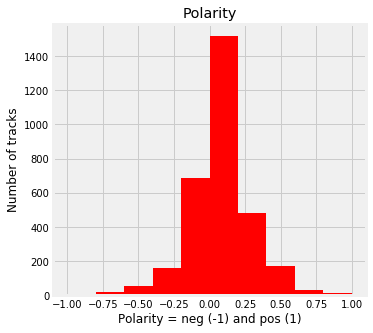

In [158]:
# Polarity
indep_train['Polarity'].plot(kind='hist', figsize=(5,5), color='red'); 
plt.xlabel('Polarity = neg (-1) and pos (1)');
plt.ylabel('Number of tracks');
plt.title('Polarity');

**Make many histograms to look at distribution**

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


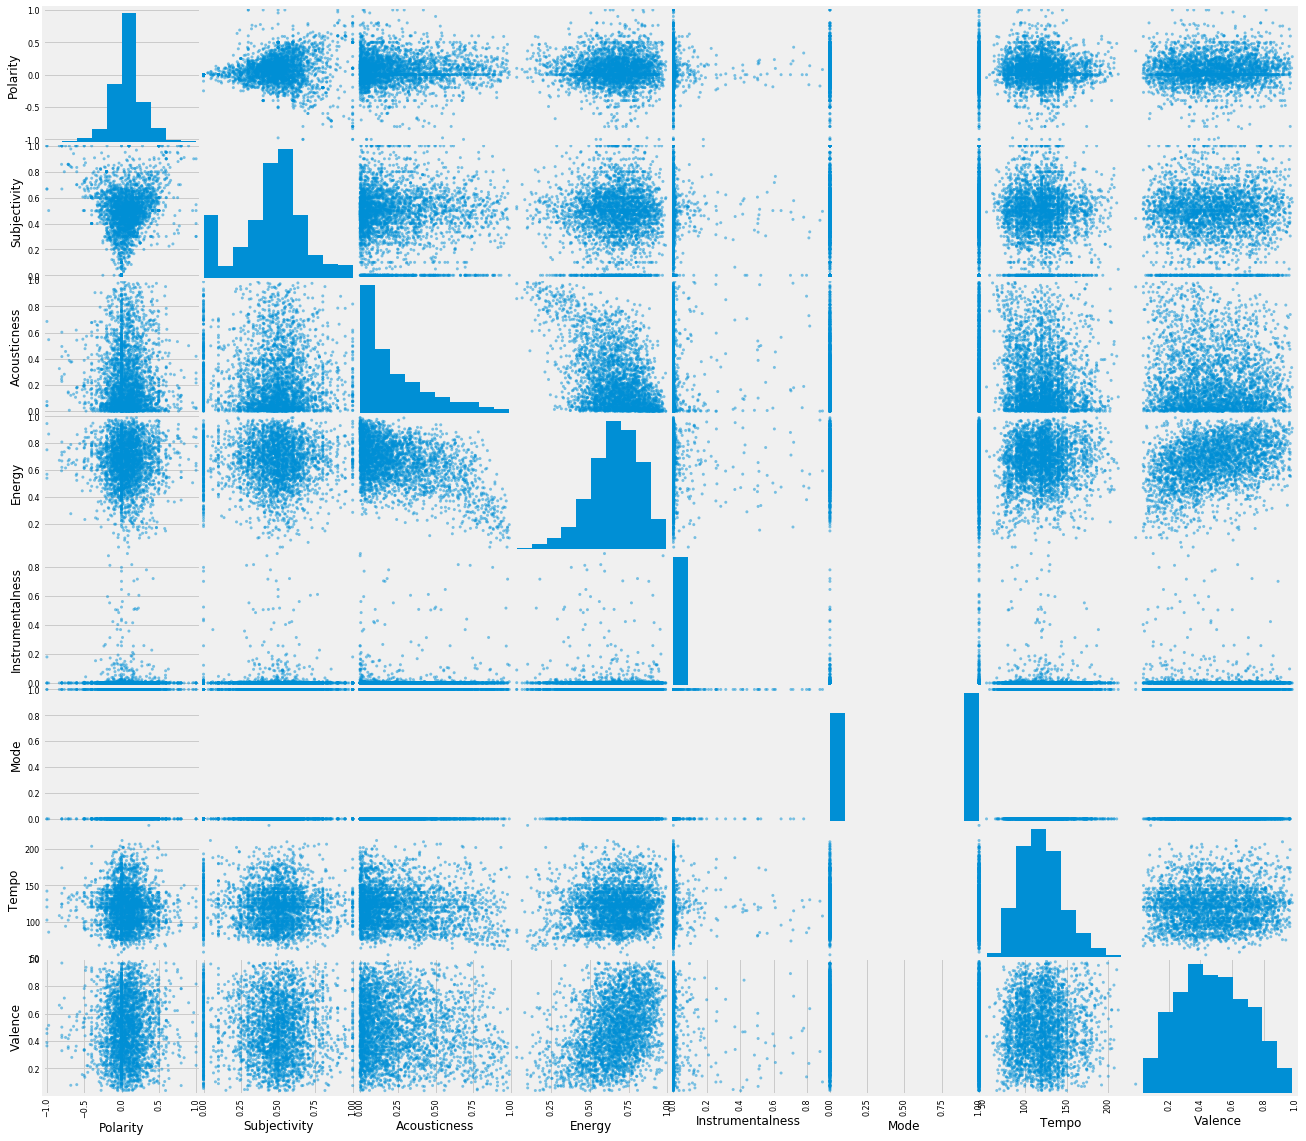

In [159]:
fig, ax = plt.subplots(figsize=(20,20))
pd.plotting.scatter_matrix(indep_train.iloc[:,[4,5,6,7,8,9,10,11]].astype(float), ax=ax);

**Make a heatmap**

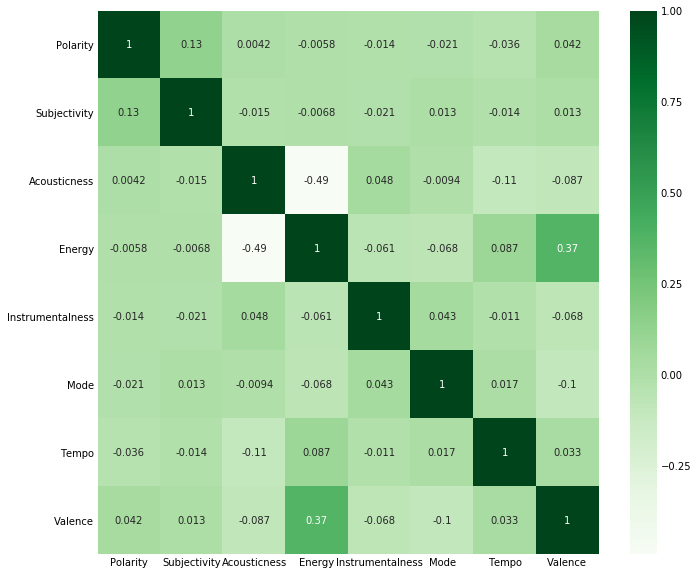

In [163]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(indep_train[['Polarity', 'Subjectivity', 'Acousticness', 'Energy', 'Instrumentalness','Mode', 
                              'Tempo', 'Valence']].corr(), annot = True, cmap="Greens")

*COMMENT: This indicates that the models only based on these column might not preform that well.*<BR />
*This is bc the Target does not have high correlation with any of the independet varables really*<BR />
*To say something positive is that the independet varables for the most are not highly correlated either.*

**Scatter plots of interesting indendent variables and the target**

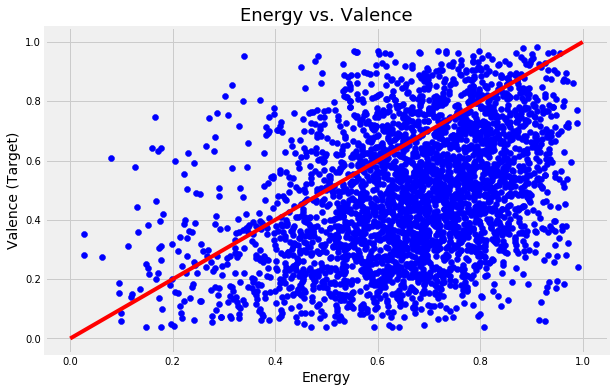

In [166]:
plt.figure(figsize=(9,6))
plt.scatter(indep_train['Energy'], indep_train['Valence'], color='blue')
plt.plot([0,1],[0,1], c='r')
plt.title('Energy vs. Valence', fontsize=18)
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Valence (Target)', fontsize=14);

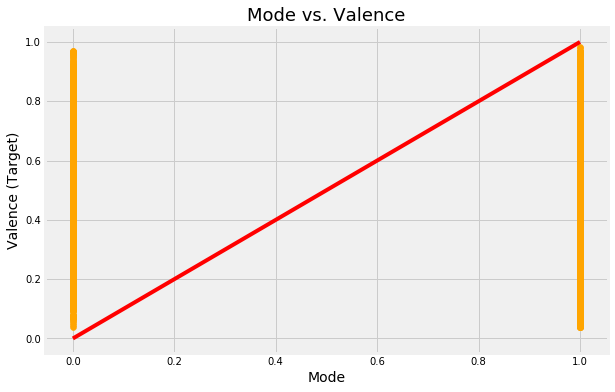

In [168]:
plt.figure(figsize=(9,6))
plt.scatter(indep_train['Mode'], indep_train['Valence'], color='orange')
plt.plot([0,1],[0,1], c='r')
plt.title('Mode vs. Valence', fontsize=18)
plt.xlabel('Mode', fontsize=14)
plt.ylabel('Valence (Target)', fontsize=14);

*COMMENT: The Mode variable does not have any range between 0 and 1. It is either 0 or 1.*

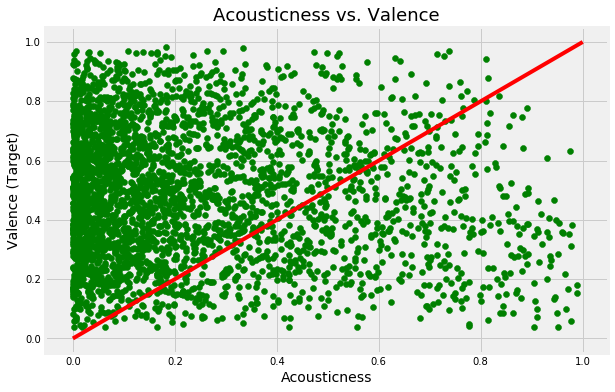

In [169]:
plt.figure(figsize=(9,6))
plt.scatter(indep_train['Acousticness'], indep_train['Valence'], color='green')
plt.plot([0,1],[0,1], c='r')
plt.title('Acousticness vs. Valence', fontsize=18)
plt.xlabel('Acousticness', fontsize=14)
plt.ylabel('Valence (Target)', fontsize=14);

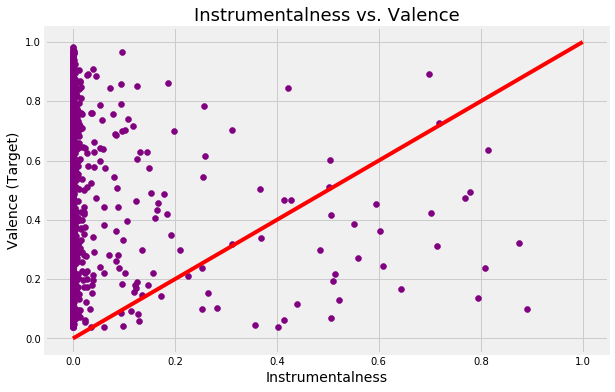

In [171]:
plt.figure(figsize=(9,6))
plt.scatter(indep_train['Instrumentalness'], indep_train['Valence'], color='purple')
plt.plot([0,1],[0,1], c='r')
plt.title('Instrumentalness vs. Valence', fontsize=18)
plt.xlabel('Instrumentalness', fontsize=14)
plt.ylabel('Valence (Target)', fontsize=14);

## Define: Happy, Neutral and Sad

### TextBlob
http://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis<BR />

**Polarity**<BR />
Range: -1.0 to +1.0 (negative, positive)<BR />

**Subjectivity**<BR />
Range: 0.0 to 1.0 (objective, subjective)


### Spotify Web API

https://developer.spotify.com/web-api/object-model/<BR />

**Acousticness**<BR />
Range: 0.0 to 1.0 (non-acoustic, acoustic)

**Energy (intensity and activity)**<BR />
Range: 0.0 to 1.0 (non-energetic, energetic)

**Instrumentalness**<BR />
Range: 0.0 to 1.0 (vocal, non-vocal)

**Mode (modality: major or minor)**<BR />
Range: 0.0 to 1.0 (monir, major)

**Tempo (BPM)**<BR />
Range: 0.0 to 1.0 (low tempo, high tempo)

**Valence (this is the target varable)**<BR />
Range: 0.0 to 1.0 (negative, positive -> sad, happy)

**SAD:**
Prediction < 0.48

**HAPPY:**
Prediction > 0.52

**Neutral:**
What is left

## Models

In [173]:
indep_train.head(3)

,Track Name,Artist,ID,Lyrics,Polarity,Subjectivity,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
216466,Atemlos durch die Nacht,Helene Fischer,5fPGpdC4tmcVMmTuJV2HRg,Wir ziehen durch die Straßen und die Clubs die...,0.0,0.00,0.049,0.730,0.000002,1.0,128.041,0.866
61231,La vita liquida,Brunori Sas,7ctWJ718cdHHqINJlRTuxF,Liquido è il mio corpo che si piega ad ogni co...,0.0,0.25,0.558,0.621,0.000026,0.0,88.065,0.585
435097,Zum ersten Mal Nintendo,Philipp Poisel,2UcgmsztMXVyPo3VgqD5Bu,wie oft wollt' ich weg von hier? anders als di...,0.6,0.60,0.543,0.481,0.000299,1.0,98.983,0.503


### Linear Regression

In [257]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score and predict with cross_val
    score = cross_val_score(model, X_test_s, y_test)
    pred = cross_val_predict(model, X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**LinReg #1 - all coefs**

In [194]:
# define X and y
X_train = indep_train.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train = indep_train['Valence'] #target
X_test = indep_test.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test = indep_test['Valence']

# chose model 
model = LinearRegression()

# call function
evaluate_model(model, X_train, X_test, y_train, y_test)

{'MSE': 0.20811917279954398, 'Score (R^2)': 0.13929019409032872}

**Importance of the coefficients**

In [204]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train.columns,model.coef_))).abs().sort_values(ascending=False)

Energy              0.093135
Acousticness        0.027626
Mode                0.015249
Instrumentalness    0.009747
Polarity            0.008908
Subjectivity        0.002833
Tempo               0.002586
dtype: float64

**LinReg #2 - top 2 coefs**

In [258]:
# define X and y
X_train2 = indep_train[['Energy', 'Acousticness']]
y_train2 = indep_train['Valence'] #target
X_test2 = indep_test[['Energy', 'Acousticness']]
y_test2 = indep_test['Valence']

# chose model 
model2 = LinearRegression()

# call function
evaluate_model(model2, X_train2, X_test2, y_train2, y_test2)

{'MSE': 0.20768832928722072, 'Score (R^2)': 0.14541495773700164}

**LinReg #3 - top 1 coefs**

In [210]:
# define X and y
X_train3 = indep_train[['Energy']]
y_train3 = indep_train['Valence'] #target
X_test3 = indep_test[['Energy']]
y_test3 = indep_test['Valence']

# chose model 
model3 = LinearRegression()

# call function
evaluate_model(model3, X_train3, X_test3, y_train3, y_test3)

{'MSE': 0.209664733626528, 'Score (R^2)': 0.1304170741057733}

*COMMENT: So far LinReg nr 2 is the best model*

### Random Forest Regressor

You do not have to scale a Random Forest.

In [253]:
def get_best_hype(model, grid, X_train, y_train):  
    # Best Hyperparameters
    gs = GridSearchCV(model, grid)
    gs.fit(X_train, y_train)
    
    # fit
    model.fit(X_train, y_train) 
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test)
    y_true = y_test
    
    # Evaluate: score and predict with cross_val
    score = cross_val_score(model, X_test, y_test, cv=4) #best cv from below
    pred = cross_val_predict(model, X_test, y_test, cv=4) #best cv from below
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Random Forest #1 - all features**

In [232]:
# Declare indep and dep
X_train4 = indep_train.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train4 = indep_train['Valence'] #target
X_test4 = indep_test.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test4 = indep_test['Valence'] #target

# Gridsearch
grid = {'n_estimators': np.arange(1, 10),
        'max_depth': np.arange(1, 10),
        'max_features' : ('auto', 'sqrt', 'log2', None),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, grid, X_train4, y_train4)

{'best_params': {'bootstrap': True,
  'max_depth': 3,
  'max_features': 'auto',
  'n_estimators': 8,
  'verbose': 0},
 'best_score': 0.13902576727206134}

In [247]:
# chose model and use best hyperparameters (from gridsearchCV)
model4 = RandomForestRegressor(max_depth=3, max_features='auto', n_estimators=8, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(model4, X_train4, X_test4, y_train4, y_test4)

{'MSE': 0.20954660164122021, 'Score (R^2)': 0.13969559449126648}

**Best cv**

In [242]:
# what is best cv to use in function 
# (after you run this cell, take best cv-value and re-run functions cell and model cell)
cv_list = [2,3,4,5,6,7,8,9,10]

for cv in cv_list:
    scores = cross_val_score(model4, X_test4, y_test4, cv=cv)
    print(scores.mean())

0.13583317937385403
0.1280251822860864
0.14126264477592415
0.12652479624436866
0.13586564498556378
0.13965148942355637
0.13200056172254163
0.14044196379949656
0.12702659721345633


**Feature importances**

In [245]:
pd.Series(dict(zip(X_train.columns,model.feature_importances_))).abs().sort_values(ascending=False)

Energy              0.844478
Acousticness        0.098303
Mode                0.026278
Instrumentalness    0.025090
Tempo               0.004258
Polarity            0.001594
Subjectivity        0.000000
dtype: float64

**Random Forest #2 - top 2 features**

In [254]:
# Declare indep and dep
X_train5 = indep_train[['Energy','Acousticness']]
y_train5 = indep_train['Valence'] #target
X_test5 = indep_test[['Energy','Acousticness']]
y_test5 = indep_test['Valence'] #target

# Gridsearch
grid = {'n_estimators': np.arange(1, 10),
        'max_depth': np.arange(1, 10),
        'max_features' : ('auto', 'sqrt', 'log2', None),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, grid, X_train5, y_train5)

{'best_params': {'bootstrap': True,
  'max_depth': 3,
  'max_features': 'auto',
  'n_estimators': 8,
  'verbose': 0},
 'best_score': 0.1385400277836859}

In [249]:
# chose model and use best hyperparameters (from gridsearchCV)
model5 = RandomForestRegressor(max_depth=3, max_features='auto', n_estimators=8, verbose=0, bootstrap=True,
                               random_state=24)

# call function
evaluate_model(model5, X_train5, X_test5, y_train5, y_test5)

{'MSE': 0.20954660164122021, 'Score (R^2)': 0.13969559449126648}

**Random Forest #3 - top 1 features**

In [251]:
# Declare indep and dep
X_train6 = indep_train[['Energy']]
y_train6 = indep_train['Valence'] #target
X_test6 = indep_test[['Energy']]
y_test6 = indep_test['Valence'] #target

# Gridsearch
grid = {'n_estimators': np.arange(1, 10),
        'max_depth': np.arange(1, 10),
        'max_features' : ('auto', 'sqrt', 'log2', None),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, grid, X_train6, y_train6)

{'best_params': {'bootstrap': True,
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 4,
  'verbose': 0},
 'best_score': 0.12963621179470075}

In [252]:
# chose model and use best hyperparameters (from gridsearchCV)
model6 = RandomForestRegressor(max_depth=2, max_features='auto', n_estimators=4, verbose=0, bootstrap=True,
                               random_state=24)

# call function
evaluate_model(model6, X_train6, X_test6, y_train6, y_test6)

{'MSE': 0.21041573193683466, 'Score (R^2)': 0.12468447171010513}

*COMMENT: So far Random Forest nr 1 and 2 are the best model*

In total the Linear Regression number 2 is the model that scores the best<BR />
R^2-score: 0.14541495773700164

**What do we predict with that model?**

In [265]:
# define X and y
X_train2 = indep_train[['Energy', 'Acousticness']]
y_train2 = indep_train['Valence'] #target
X_test2 = indep_test[['Energy', 'Acousticness']]
y_test2 = indep_test['Valence'] #target

# chose model 
model2 = LinearRegression()

# call function
evaluate_model(model2, X_train2, X_test2, y_train2, y_test2)

# standardize the predictors
ss = StandardScaler()
ss.fit(X_train)
X_train2_s = ss.transform(X_train)
X_test2_s = ss.transform(X_test)
    
# fit
model.fit(X_train2_s, y_train2)
    
# predict
pred = cross_val_predict(model, X_test2_s, y_test2)
    
print(pred)

[0.51899046 0.48939915 0.40176333 ... 0.33687371 0.53074255 0.34891541]


In [267]:
len(pred)

1048

In [269]:
len(indep_test)

1048

In [270]:
indep_test_pred = indep_test.copy()

In [271]:
indep_test_pred['Prediction'] = pred

In [272]:
indep_test_pred.head()

,Track Name,Artist,ID,Lyrics,Polarity,Subjectivity,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,Prediction
62688,King Of The North,Bugzy Malone,4DixkYsZqImKOmjaIaYnCi,King! King! King! King! King! King!\nI'm King ...,0.104433,0.491386,0.0778,0.772,0.000044,0.0,139.886,0.376,0.518990
203623,Back On,Gucci Mane,0KA5Cc68h9qitLwTadHBpa,Zaytoven\nHah\nWop\nYeah\nIt's Gucci\nZay\nZig...,0.034028,0.259722,0.0087,0.639,0.000004,1.0,156.055,0.427,0.489399
116827,Magazine,Dark Polo Gang,71MGHgauMD6aapixtV6Chd,"Hey, hey\nSick Luke, Sick Luke\n\nLa mia facci...",-0.200298,0.519048,0.3960,0.437,0.000000,1.0,136.111,0.525,0.401763
369046,Happy Christmas (War Is Over),Maroon 5,2F8GPfzDGBTz3vuPkOxLXJ,So this is Christmas\nAnd what have you done?\...,0.240863,0.497406,0.9390,0.183,0.000002,1.0,142.944,0.172,0.301605
259810,Meters,Josylvio,7H5Kqq4zbqPkaCfMeQBJIq,"Ik ben on my way\nMaak meters, Churandy Martin...",0.025000,0.000000,0.3910,0.911,0.001870,1.0,149.969,0.785,0.650811


In [ ]:
# The prediction

In [281]:
indep_test_pred['Prediction'].max()

0.657386869793577

In [282]:
indep_test_pred['Prediction'].min()

0.2476869139923566

In [283]:
# songs that are sad
len(indep_test_pred[indep_test_pred['Prediction'] < 0.48])/len(pred)

0.42270992366412213

In [284]:
# songs that are happy
len(indep_test_pred[indep_test_pred['Prediction'] > 0.52])/len(pred)

0.36259541984732824

In [285]:
# songs that are neutral
1 -(len(indep_test_pred[indep_test_pred['Prediction'] < 0.45])/len(pred))-(len(indep_test_pred[indep_test_pred['Prediction'] > 0.55])/len(pred))

0.3950381679389313

In [ ]:
# The target

In [286]:
indep_test_pred['Valence'].max()

0.973

In [287]:
indep_test_pred['Valence'].min()

0.0378

In [291]:
# songs that are sad
len(indep_test_pred[indep_test_pred['Valence'] < 0.48])/len(indep_test_pred['Valence'])

0.5124045801526718

In [292]:
# songs that are happy
len(indep_test_pred[indep_test_pred['Valence'] > 0.52])/len(indep_test_pred['Valence'])

0.42270992366412213

In [293]:
# songs that are neutral
1 -(len(indep_test_pred[indep_test_pred['Valence'] < 0.45])/len(indep_test_pred['Valence']))-(len(indep_test_pred[indep_test_pred['Valence'] > 0.55])/len(indep_test_pred['Valence']))

0.13645038167938933

**We can conclude that this model was really bad at making predictions!**<BR />
**The range is much smaller and if you look at specific songs it does not look right.**